# Airbus Impact Project

In [ ]:
# Imports
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
from numpy import quantile, where, random
import datetime
import plotly.express as px
import plotly.graph_objs as go
from matplotlib import pyplot as plt, dates
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

### Import Datasets

In [ ]:
filenames = ["data/msn_02_fuel_leak_signals_preprocessed.csv", 
             "data/msn_10_fuel_leak_signals_preprocessed.csv", 
             "data/msn_11_fuel_leak_signals_preprocessed.csv", 
             "data/msn_12_fuel_leak_signals_preprocessed.csv", 
             "data/msn_14_fuel_leak_signals_preprocessed.csv", 
             "data/msn_29_fuel_leak_signals_preprocessed.csv", 
             "data/msn_37_fuel_leak_signals_preprocessed.csv", 
             "data/msn_53_fuel_leak_signals_preprocessed.csv"]

datasets = []
datasets_labels = ["MSN_02", "MSN_10", "MSN_11", "MSN_12", "MSN_14", "MSN_29", "MSN_37", "MSN_53", "MSN_37_LEAK0.5", "MSN_37_LEAK1.0", "MSN_37_LEAK5.0"]
                   
for filename in filenames:
    datasets.append(pd.read_csv(filename, sep=";"))
    
for i in range(3):
    datasets.append(datasets[6].copy())
    
print("Datasets loaded")

Define Date and Time Columns

In [ ]:
for dataset in datasets:
    #introduce column date
    dataset['UTC_TIME'] = pd.to_datetime(dataset['UTC_TIME'])
    dataset['DATE'] = dataset['UTC_TIME'].dt.date
    dataset["TIME"] = dataset['UTC_TIME'].dt.time

Check for Records and Features for every dataset

In [ ]:
data = {}

data['Records'] = [dataset.shape[0] for dataset in datasets]
data['Features'] = [dataset.shape[1] for dataset in datasets]

pd.DataFrame(data, index = datasets_labels)

Display columns in all datasets

In [ ]:
for dataset in datasets:
    print(dataset.info(verbose=True))

Print Total Null values and relative Null values

In [ ]:
pd.DataFrame({'NULL_VALUES': datasets[0].isnull().sum(), 'NULL_VALUES_%': datasets[0].isnull().sum() / datasets[0].shape[0] * 100, 'UNIQUE VALUES': datasets[0].nunique()})

In [ ]:
# Do the same for all datasets
df_feat = pd.DataFrame()

for i in range(1, len(datasets)):
    df_tmp = pd.DataFrame({f'{datasets_labels[i]}_miss': datasets[i].isnull().sum(), 
                           f'{datasets_labels[i]}_miss_%': datasets[i].isnull().sum() / datasets[i].shape[0] * 100, 
                           f'{datasets_labels[i]}_unique': datasets[i].nunique()})
    df_feat = pd.concat([df_feat, df_tmp], axis=1)
    
df_feat

In [ ]:
# print relative amount of flight phase 8
print("Relative amount of flight phases 3-11")
for dataset in datasets:
    print(dataset[dataset['FLIGHT_PHASE_COUNT'].isin(list(range(3,12)))].shape[0] / dataset.shape[0] * 100)
    
print("\nRelative amount of rows with NaN values in flight phases 3-11")
# count rows with NaN values in flight phases 3-11
for dataset in datasets:
    print(dataset[dataset['FLIGHT_PHASE_COUNT'].isin(list(range(3,12)))].isnull().any(axis=1).sum() / dataset.shape[0] * 100)


In [ ]:
records_total = sum([dataset.shape[0] for dataset in datasets])
records_dropna = sum([dataset.dropna().shape[0] for dataset in datasets])

records_dropna_flightphase = {
    i: sum([dataset[dataset['FLIGHT_PHASE_COUNT'] == i].dropna().shape[0] for dataset in datasets])
    for i in range(1, 13)
}

print("Total records:", records_total)
print("Records after dropna:", records_dropna)
print("Records after dropna per flight phase:", records_dropna_flightphase)

In [ ]:
# Drop rows with duplicats in UTC_TIME
for dataset in datasets:
    dataset.drop_duplicates(subset=['UTC_TIME'], inplace=True)

In [ ]:
df_tmp = pd.DataFrame(records_dropna_flightphase, index=['Records']).transpose()
 
fig = px.bar(df_tmp, x=df_tmp.index, y='Records', title='Records after dropna per flight phase')
fig.show()


In [ ]:
for i, dataset in enumerate(datasets):
    df_tmp = dataset.dropna()
    flight_phase_count = df_tmp['FLIGHT_PHASE_COUNT'].value_counts()
    
    #plot bar chart for flight phase count
    fig = px.bar(flight_phase_count, x=flight_phase_count.index, y='FLIGHT_PHASE_COUNT', title=f'Flight phase count for {datasets_labels[i]}')
    fig.show()
    
    

Calculate std in tanks by flight-phase

In [ ]:
datasets_dropna = [df.dropna() for df in datasets]
all_datasets = pd.concat(datasets_dropna, ignore_index=True)

columns_to_describe = [
    'FUEL_USED_1', 
    'FUEL_USED_2', 
    'FUEL_USED_3', 
    'FUEL_USED_4', 
    'VALUE_FUEL_QTY_CT', 
    'VALUE_FUEL_QTY_RXT', 
    'VALUE_FUEL_QTY_LXT', 
    'VALUE_FUEL_QTY_FT1', 
    'VALUE_FUEL_QTY_FT2', 
    'VALUE_FUEL_QTY_FT3', 
    'VALUE_FUEL_QTY_FT4'
]

std_df = all_datasets.groupby('FLIGHT_PHASE_COUNT')[columns_to_describe].std().reset_index()
std_df.columns = ['FLIGHT_PHASE'] + [f'{col}_std' for col in columns_to_describe]

Show Dataframe with lowest and highest value marked in green and red

In [ ]:
# mark the highest value in each column red and lowest green and the middle yellow
def highlight_max(s):
    is_max = s == s.max()
    is_min = s == s.min()
    is_middle = s == s.median()
     
    return ['background-color: red' if v else 'background-color: green' if w else 'background-color: yellow' if x else '' for v, w, x in zip(is_max, is_min, is_middle)]
 
std_df.style.apply(highlight_max)

### Assign to each concetenated flight a unique flight number and only keep flight_phases 3 - 11

In [ ]:
columns_where_to_drop_nan = datasets[2].columns

def introduce_flight_column(dataset):
    # copy dataset
    dataset_tmp = dataset.copy()
    
    # Drop NaN values
    dataset_tmp = dataset_tmp.dropna(subset=columns_where_to_drop_nan)
    
    # Variable to store flight number
    flight_number = 0
    
    # assign flight number to rows that have indexes following each other
    # if the difference between two indexes is greater than 1, a new flight is assumed
    print(dataset_tmp.shape)
    
    for i in range(1, dataset_tmp.shape[0]):
        if dataset_tmp.index[i] - dataset_tmp.index[i-1] > 1:
            flight_number += 1
        dataset_tmp.at[dataset_tmp.index[i], 'FLIGHT'] = flight_number
        
    # Fill nan values in flight column with 0
    dataset_tmp['FLIGHT'] = dataset_tmp['FLIGHT'].fillna(0)
    
    # only keep rows with flight_phase_count between 3-11
    # dataset_tmp = dataset_tmp[(dataset_tmp['FLIGHT_PHASE_COUNT'] >= 3) & (dataset_tmp['FLIGHT_PHASE_COUNT'] <= 11)]
        
    # return dataset with flight column
    return dataset_tmp[dataset_tmp['FLIGHT_PHASE_COUNT'].isin(list(range(2,12)))]
   

## New Features

In [ ]:
def define_new_features(dataset):
    # copy dataset
    dataset_tmp = dataset.copy()
    
    dataset_tmp['TOTAL_FUEL_USED'] = 0
     
    # Total fuel column is the sum of all fuel used columns
    for i in range(1, 5):
        dataset_tmp['TOTAL_FUEL_USED'] += dataset_tmp['FUEL_USED_' + str(i)]
        
    # Get difference for VALUE_FOB. For each flight the first value must be 0
    dataset_tmp['VALUE_FOB_DIFF'] = dataset_tmp.groupby('FLIGHT')['VALUE_FOB'].diff()
    
    dataset_tmp['VALUE_FOB_DIFF'] = dataset_tmp['VALUE_FOB_DIFF'].fillna(0)
    
    dataset_tmp['TOTAL_FOB_BY_QTY'] = dataset_tmp['VALUE_FUEL_QTY_CT'] + dataset_tmp['VALUE_FUEL_QTY_FT1'] + dataset_tmp['VALUE_FUEL_QTY_FT2'] + dataset_tmp['VALUE_FUEL_QTY_FT3'] + dataset_tmp['VALUE_FUEL_QTY_FT4'] + dataset_tmp['VALUE_FUEL_QTY_LXT'] + dataset_tmp['VALUE_FUEL_QTY_RXT']
    
    dataset_tmp['DELTA_VFOB_VS_VFOBQTY'] = dataset_tmp['VALUE_FOB'] - dataset_tmp['TOTAL_FOB_BY_QTY']
    
    dataset_tmp['ALTITUDE_DIFF'] = dataset_tmp['FW_GEO_ALTITUDE'].diff().abs()    
    
    # for each FLIGHT substract the first value of TOTAL_FUEL_USED from all values
    #for flight in dataset_tmp['FLIGHT'].unique():
    #    dataset_tmp.loc[dataset_tmp['FLIGHT'] == flight, 'TOTAL_FUEL_USED'] -= dataset_tmp[dataset_tmp['FLIGHT'] == flight]['TOTAL_FUEL_USED'].iloc[0]
   
    
    return dataset_tmp

Deleting Values before all Fuel_Used Columns are resetted

In [ ]:
def subtract_first(x):
    return x.iloc[0] - x

def initalize_flights(dataset):
    # copy dataset
    dataset_tmp = dataset.copy()
     
    for flight_num in dataset_tmp['FLIGHT'].unique():
        # get first index of flight 
        first_index = dataset_tmp[dataset_tmp['FLIGHT'] == flight_num].index[0]
        
        # get last index of flight
        last_index = dataset_tmp[dataset_tmp['FLIGHT'] == flight_num].index[-1]
        
        # get location of min value of VALUE_FOB per flight 
        min_value_sum_fuel_used = dataset_tmp[dataset_tmp['FLIGHT'] == flight_num]['TOTAL_FUEL_USED'].idxmin()
        
        # delete in dataset_tmp all rows between first_location and min_value_fob
        dataset_tmp.drop(dataset_tmp.loc[first_index:min_value_sum_fuel_used].index, inplace=True)
        
        # dataset_tmp["VALUE_FOB_MISSING"] = dataset_tmp.groupby('FLIGHT')['VALUE_FOB'].transform(subtract_first)
        
    return dataset_tmp

In [ ]:
datasets_unique_flight = [introduce_flight_column(dataset) for dataset in datasets_dropna]

In [ ]:
datasets_with_new_features = [define_new_features(dataset) for dataset in datasets_unique_flight]

In [ ]:
datasets_without_reset_engines = [initalize_flights(dataset) for dataset in datasets_with_new_features]

In [ ]:
for dataset in datasets_without_reset_engines:
    dataset['VALUE_FOB_MISSING'] = dataset.groupby('FLIGHT')['VALUE_FOB'].transform(subtract_first)

In [ ]:
for i, dataset in enumerate(datasets_without_reset_engines):
    print(f'Dataset {i} shape: {dataset.shape}')
    print(f'Dataset {i} unique flights: {dataset["FLIGHT"].nunique()}')

Plot Altitude vs Value Fob for dataset 0

Plot Altitude vs Value Fob for the rest of the datasets

In [ ]:
flight_phase_dict = {
    1: 'Pre-flight',
    2: 'Engine Run',
    3: 'Take-Off 1',
    4: 'Take-Off 2',
    5: 'Take-Off 3',
    6: 'Climbing 1',
    7: 'Climbing 2',
    8: 'Cruise',
    9: 'Descent',
    10: 'Approach',
    11: 'Landing',
    12: 'Post-flight'
}

def plot_flight(dataset, min_flight_length=100, max_graphs=10):
    for flight_num in dataset["FLIGHT"].unique(): 
        fig = go.Figure()

        # Define data for flight
        flight_data = dataset[dataset['FLIGHT'] == flight_num]
        
        if flight_data.shape[0] < min_flight_length:
            continue
        
        # Define traces
        fig.add_trace(go.Scatter(x=flight_data['UTC_TIME'],
                                y=flight_data['VALUE_FOB'],
                                mode='lines',
                                name='VALUE_FOB')) 

        fig.add_trace(go.Scatter(x=flight_data['UTC_TIME'],
                                y=flight_data['FW_GEO_ALTITUDE'],
                                mode='lines',
                                name='FW_GEO_ALTITUDE'))
        
        # add trace for total_fuel_used
        fig.add_trace(go.Scatter(x=flight_data['UTC_TIME'],
                                    y=flight_data['TOTAL_FUEL_USED'],
                                    mode='lines',
                                    name='TOTAL_FUEL_USED'))
        
        # add trace for VALUE_FOB_DIFF
        fig.add_trace(go.Scatter(x=flight_data['UTC_TIME'],
                                    y=flight_data['VALUE_FOB_DIFF'],
                                    mode='lines',
                                    name='VALUE_FOB_DIFF'))
        
        
        fig.add_trace(go.Scatter(x=flight_data['UTC_TIME'],
                                    y=flight_data['VALUE_FOB_MISSING'],
                                    mode='lines',
                                    name='VALUE_FOB_MISSING'))
        
        
        for flight_phase in flight_data['FLIGHT_PHASE_COUNT'].unique():
            fig.add_trace(go.Scatter(x=flight_data[flight_data['FLIGHT_PHASE_COUNT'] == flight_phase]['UTC_TIME'],
                                    y=flight_data[flight_data['FLIGHT_PHASE_COUNT'] == flight_phase]['VALUE_FOB'],
                                    mode='lines',
                                        name=f'{flight_phase}, {flight_phase_dict[flight_phase]}'))

        fig.update_layout(title=f'VALUE_FOB and FW_GEO_ALTITUDE for flight {flight_num}',
                        xaxis_title='UTC_TIME',
                        yaxis_title='VALUE_FOB and FW_GEO_ALTITUDE')
        
        # Define rectangles for different flight phases
        shapes = []
        colors = [
        'LightSkyBlue', 'LightSalmon', 'LightGreen', 'LightYellow', 'LightPink', 
        'MediumPurple', 'DarkOrange', 'MediumSeaGreen', 'DeepSkyBlue']
        # Define more colors if needed
        for i, flight_phase in enumerate(flight_data['FLIGHT_PHASE_COUNT'].unique()):
            phase_data = flight_data[flight_data['FLIGHT_PHASE_COUNT'] == flight_phase]
            shapes.append(
                go.layout.Shape(
                    type="rect",
                    xref="x",
                    yref="paper",  # use 'paper' to refer to the entire y range
                    x0=phase_data['UTC_TIME'].min(),
                    x1=phase_data['UTC_TIME'].max(),
                    y0=0,
                    y1=1,
                    fillcolor=colors[i % len(colors)],
                    opacity=0.5,
                    layer="below",
                    line_width=0,
                )
            )
        
        fig.update_layout(shapes=shapes)
        fig.show()
        
        max_graphs -= 1
        
        if(max_graphs == 0):    
            break
        
        


In [ ]:
plot_flight(datasets_without_reset_engines[1], min_flight_length=500, max_graphs=3)

In [ ]:
datasets_without_reset_engines[3]

## Bring all datasets to the same shape

In [ ]:
# Define functions to drop so that all datasets have the same columns
columns_to_drop = [column for column in datasets_without_reset_engines[0].columns if column not in datasets_without_reset_engines[2].columns]

datasets_without_reset_engines[0].drop(columns_to_drop, axis=1, inplace=True) 

In [ ]:
# shape of datasets
for i, dataset in enumerate(datasets_without_reset_engines):
    print(f'Dataset {i} shape: {dataset.shape}')
    print(f'Dataset {i} unique flights: {dataset["FLIGHT"].nunique()}')

# Dropping Outliers

In [ ]:
# define all numeric columns
numeric_columns = ['FUEL_USED_2',
 'FUEL_USED_3',
 'FUEL_USED_4',
 'FW_GEO_ALTITUDE',
 'VALUE_FOB',
 'VALUE_FUEL_QTY_CT',
 'VALUE_FUEL_QTY_FT1',
 'VALUE_FUEL_QTY_FT2',
 'VALUE_FUEL_QTY_FT3',
 'VALUE_FUEL_QTY_FT4',
 'VALUE_FUEL_QTY_LXT',
 'VALUE_FUEL_QTY_RXT',
 'FLIGHT_PHASE_COUNT',
 'FUEL_USED_1',
 'TOTAL_FUEL_USED',
 'VALUE_FOB_DIFF',
 'TOTAL_FOB_BY_QTY',
 'DELTA_VFOB_VS_VFOBQTY',
 'ALTITUDE_DIFF',
 'VALUE_FOB_MISSING']

# function to drop outliers greater than 3 standard deviations for all columns
def drop_outliers(dataset):
    return dataset[(np.abs(stats.zscore(dataset[numeric_columns])) < 3).all(axis=1)]

In [ ]:
datasets_without_outliers = [drop_outliers(dataset) for dataset in datasets_without_reset_engines]

In [ ]:
# remove second dataset from list as it has not enough data
datasets_without_outliers.pop(1)

In [ ]:
datasets_without_outliers

## Merge all datasets

In [ ]:
# merge all datasets into one
merged_dataset = pd.concat(datasets_without_outliers)

In [ ]:
import seaborn as sns

# heatmap for numeric columns
fig = plt.figure(figsize=(20, 20))
sns.heatmap(merged_dataset[numeric_columns].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()


In [ ]:
merged_dataset

## Scaling

In [ ]:
# define scaler
scaler = StandardScaler()
 
# fit_transform on merged dataset
scaled_data = scaler.fit_transform(merged_dataset[numeric_columns])

# convert scaled_dataset to dataframe
scaled_dataset = pd.DataFrame(scaled_data, columns=numeric_columns)

scaled_dataset

In [ ]:
np.mean(scaled_dataset),np.std(scaled_dataset)

In [ ]:
# save scaled dataset to csv
scaled_dataset.to_csv('data/scaled_dataset.csv', index=False)

## PCA

In [ ]:
scaled_data = pd.read_csv('data/scaled_dataset.csv')

In [ ]:
num_components = 15

# Create a PCA instance
pca = PCA(n_components=num_components)  

# Fit PCA on scaled_data
pca.fit(scaled_data)
 
# access values and vectors
print(pca.components_)
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())
 
# transform data 
pca_data = pca.transform(scaled_data)
 
# convert pca_data to dataframe
pca_dataset = pd.DataFrame(pca_data, columns=[f'PC{i}' for i in range(1, num_components+1)])

In [ ]:
# plot percentage and cumulative percentage of variance explained by each principal component 
fig = plt.figure(figsize=(10, 5))
plt.bar(range(1, num_components+1), pca.explained_variance_ratio_, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1, num_components+1), pca.explained_variance_ratio_.cumsum(), where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

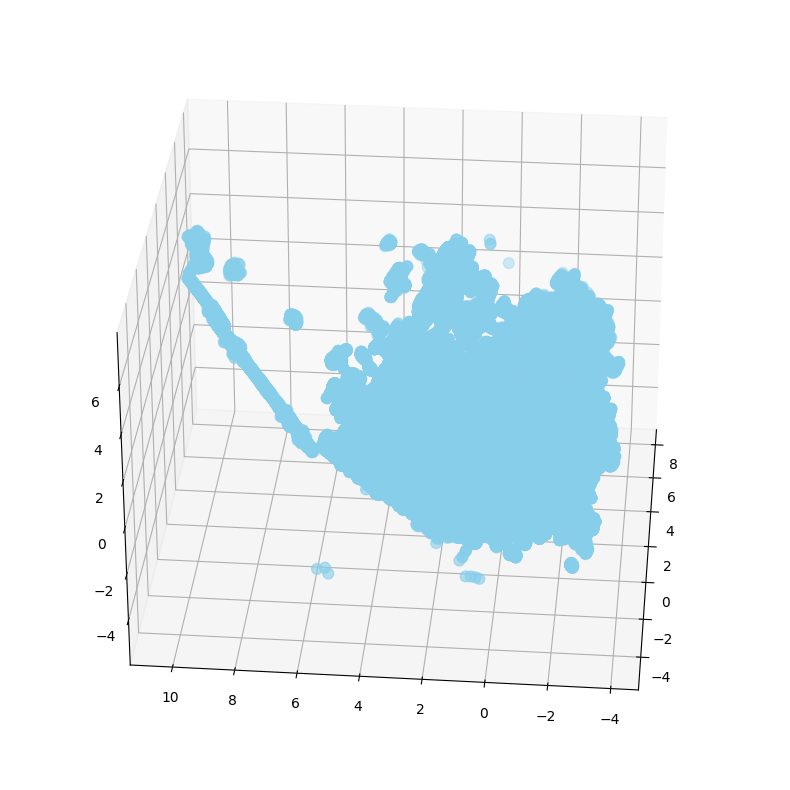

In [8]:
# 3d plot of first 3 principal components that is interactive
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
 
ax.scatter(pca_dataset['PC1'], pca_dataset['PC2'], pca_dataset['PC3'], c='skyblue', s=60) 
ax.view_init(30, 185)
plt.show()


In [ ]:
# in df_test plot TOTAL_FUEL_USED for each flight
for flight in df_test['FLIGHT'].unique():
    # count number of rows for each flight
    if df_test[df_test['FLIGHT'] == flight].shape[0] > 1:
        # plot TOTAL_FUEL_USED for each flight x = UTC_TIME, y = TOTAL_FUEL_USED only plot if FLIGHT_PHASE_COUNT == 8
        if df_test[df_test['FLIGHT'] == flight]['FLIGHT_PHASE_COUNT'].iloc[0] == 2:
            plt.plot(df_test[df_test['FLIGHT'] == flight]['UTC_TIME'], df_test[df_test['FLIGHT'] == flight]['VALUE_FOB_DIFF'])
            plt.show()

In [ ]:
# for each flight and each flightphase calculate the std of VALUE_FOB_DIFF 

results = []
for flight in df_test['FLIGHT'].unique():
    result = {}
    for flightphase in df_test[df_test['FLIGHT'] == flight]['FLIGHT_PHASE_COUNT'].unique():
        result['FLIGHT'] = flight
        result['FLIGHT_PHASE'] = flightphase
        result['VALUE_FOB_DIFF_std'] = df_test[(df_test['FLIGHT'] == flight) & (df_test['FLIGHT_PHASE_COUNT'] == flightphase)]['VALUE_FOB_DIFF'].std()
        results.append(result)
        
results_df = pd.DataFrame(results)

pd.pivot_table(results_df, values='VALUE_FOB_DIFF_std', index=['FLIGHT'], columns=['FLIGHT_PHASE'], aggfunc=np.sum,  fill_value=0).sort_values(by=[11], ascending=False)


In [ ]:
# plot for dataset 0 for column LEAK_DETECTION_LEAK_FLOW
datasets[0].plot.scatter(x='UTC_TIME', y='LEAK_DETECTION_LEAK_FLOW')

In [ ]:
import plotly.graph_objects as go
import pandas as pd

# Extract numeric part from 'Flight' column
datasets[0]['Flight_number'] = datasets[0]['Flight'].str.extract('(\d+)').astype(int)

# Sort DataFrame by 'Flight_number'
sorted_df = datasets[0].sort_values(by='Flight_number')

fig = go.Figure()

# boxplot for sorted DataFrame for column VALUE_FOB.
fig.add_trace(go.Box(
    x= sorted_df['Flight'], 
    y= sorted_df['VALUE_FOB'], 
    name= 'VALUE_FOB',
    line=dict(color='green'),  # change boxplot color to green
    marker=dict(color='green') # change marker color to green
))

# Calculate mean for each flight in the sorted DataFrame
mean_fob = sorted_df.groupby('Flight')['VALUE_FOB'].mean()

# Add a scatter plot for the mean values
fig.add_trace(go.Scatter(
    x=mean_fob.index, 
    y=mean_fob.values, 
    mode='lines', 
    name='Mean',
    line=dict(color='purple')  # set line color to purple
))

fig.update_layout(
    title_text="Boxplot for sorted dataset for column VALUE_FOB", 
    xaxis_title="Flight", 
    yaxis_title="VALUE_FOB",
    plot_bgcolor='black',  # set plot background color to black
    paper_bgcolor='black',  # set paper background color to black
    font=dict(color='white'),  # set font color to white
    autosize=False,
    width=1000,
    height=600
)

fig.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cat_features02 = [col for col in datasets[0] if datasets[0][col].dtypes.name == 'bool']
features02 = [col for col in datasets[0] if col not in cat_features02 if 'STATUS' not in col if 'MODE' not in col if col not in ["day", "month", "time", "year", "SELECTED_GADIR_ALTITUDE_VALUE", "VALUE_FUEL_VOL_LST", "VALUE_FUEL_VOL_RST", "FLIGHT_PHASE_COUNT", "APU_FUEL_FLOW_REQUEST_SIGNAL_1"]]

fig, ax = plt.subplots(figsize=(30,25)) 
sns.heatmap(msn02_smooth[features02].corr(), cmap="RdBu", annot=True, ax=ax)
plt.xticks(rotation=45, ha='right')


In [ ]:
import plotly.subplots as sp
import plotly.graph_objs as go

def plot_datasets(dataset):
    # List of columns to plot for VALUE_FUEL_QTY_CT;VALUE_FUEL_QTY_FT1;VALUE_FUEL_QTY_FT2;VALUE_FUEL_QTY_FT3;VALUE_FUEL_QTY_FT4;VALUE_FUEL_QTY_LXT;VALUE_FUEL_QTY_RXT
    fuel_qty_cols = ['VALUE_FUEL_QTY_CT', 'VALUE_FUEL_QTY_LXT', 'VALUE_FUEL_QTY_RXT', 'VALUE_FUEL_QTY_FT1', 'VALUE_FUEL_QTY_FT2', 'VALUE_FUEL_QTY_FT3', 'VALUE_FUEL_QTY_FT4']

    # Loop over every unique date
    for date in dataset['DATE'].unique():
        for flight in dataset['MSN'].unique():
            # Create a subplot
            fig = sp.make_subplots(rows=3, cols=3)
            
            # size of fig 
            fig.update_layout(height=1400, width=1400)

            # Loop over each column
            for i, col in enumerate(fuel_qty_cols):
                # save the dataset for the current date and flight
                dataset_tmp = dataset[(dataset['DATE'] == date) & (dataset['MSN'] == flight)]
                # Add scatter plot to subplot
                fig.add_trace(
                    go.Scatter(x=dataset_tmp['UTC_TIME'], 
                            y=dataset_tmp[col], 
                            mode='markers',
                            name=col),
                    row=i//3 + 1, 
                    col=i%3 + 1
                )

                # Update xaxis and yaxis titles
                fig.update_xaxes(title_text='UTC_TIME', row=i//3 + 1, col=i%3 + 1)
                fig.update_yaxes(title_text=col + " " + str(date), row=i//3 + 1, col=i%3 + 1)

            # Show the plot
            #fig.show()
            
            # save the plot as png
            fig.write_image("plots2/" + str(date) +"-" + str(flight) + ".png")
     
            
#plot_datasets(datasets[1])

#for i in range(len(datasets)):
 #   if i > 1:
  #      plot_datasets(datasets[i])

In [ ]:
def plot_dataset_for_date(dataset, date, flight_phase):
    # List of columns to plot for VALUE_FUEL_QTY_CT;VALUE_FUEL_QTY_FT1;VALUE_FUEL_QTY_FT2;VALUE_FUEL_QTY_FT3;VALUE_FUEL_QTY_FT4;VALUE_FUEL_QTY_LXT;VALUE_FUEL_QTY_RXT
    fuel_qty_cols = ['VALUE_FUEL_QTY_CT', 'VALUE_FUEL_QTY_LXT', 'VALUE_FUEL_QTY_RXT', 'VALUE_FUEL_QTY_FT1', 'VALUE_FUEL_QTY_FT2', 'VALUE_FUEL_QTY_FT3', 'VALUE_FUEL_QTY_FT4']

    # Loop over every unique date
    for flight in dataset['MSN'].unique():
        # Create a subplot
        fig = sp.make_subplots(rows=3, cols=3)

        # size of fig 
        fig.update_layout(height=1000, width=1200)

        # Loop over each column
        for i, col in enumerate(fuel_qty_cols):
            # save the dataset for the current date and flight
            dataset_tmp = dataset[(dataset['DATE'] == date) & (dataset['MSN'] == flight) & (dataset['FLIGHT_PHASE_COUNT'] == flight_phase)]
            # Add scatter plot to subplot

            fig.add_trace(
                go.Scatter(x=dataset_tmp['UTC_TIME'], 
                        y=dataset_tmp[col], 
                        mode='markers',
                        name=col),
                row=i//3 + 1, 
                col=i%3 + 1
            )

            # Update xaxis and yaxis titles
            fig.update_xaxes(title_text='UTC_TIME', row=i//3 + 1, col=i%3 + 1)
            fig.update_yaxes(title_text=col + " " + str(date), row=i//3 + 1, col=i%3 + 1)

    # Show the plot
    fig.show()

In [ ]:
plot_dataset_for_date(datasets[1], datetime.date(2015, 3, 7), 8.0)

In [ ]:
datasets[6][['DATE', 'MSN', 'FLIGHT_PHASE_COUNT']][datasets[6]['FLIGHT_PHASE_COUNT'] == 8.0]

In [ ]:
# function to add leakage data to the dataset
def add_leakage_data(dataset, leakage_qty):
    # substract leakage_qty from VALUE_FOB col
    dataset['VALUE_FOB'] = dataset['VALUE_FOB'] - (leakage_qty / 60)
    
    # add column FUEL_USED_BY_FOB to dataset
    # first column is 0 because we don't know the fuel used at the start of the flight
    # every next row is the row + difference between the current and previous row in VALUE_FOB
    dataset['FUEL_USED_BY_FOB'] = 0
    for i in range(1, dataset.shape[0]):
        dataset['FUEL_USED_BY_FOB'].iloc[i] = dataset['FUEL_USED_BY_FOB'].iloc[i-1] + (dataset['VALUE_FOB'].iloc[i] - dataset['VALUE_FOB'].iloc[i-1])
    
        

In [ ]:
add_leakage_data(datasets[8], 0.5)
add_leakage_data(datasets[9], 1.0)
add_leakage_data(datasets[10], 5.0)

In [ ]:
def relative_fuel_used(dataset):
    nulls = dataset[dataset['FLIGHT_PHASE_COUNT'] == 8.0]["FUEL_USED_1"].isnull().sum()
    shape_0 = dataset[dataset['FLIGHT_PHASE_COUNT'] == 8.0].shape[0]
    
    print(f"dataset_{1}", nulls / shape_0)
    
for dataset in datasets:
    relative_fuel_used(dataset)

In [ ]:
# plot for dataset 6 for 2016-07-27, flightphase 8
# plot columns VALUE_FOB and FUEL_USED_BY_FOB
dataste_tmp = datasets[0][(datasets[0]['FLIGHT_PHASE_COUNT'] == 8.0) & (datasets[0]['DATE'] == datetime.date(2011, 3, 9))]

dataste_tmp['VALUE_FOB_LEAKAGE'] = dataste_tmp['VALUE_FOB'] - (5.0)

dataste_tmp["TOTAL_CONSUMPTION"] = dataste_tmp["FUEL_USED_1"] + dataste_tmp["FUEL_USED_2"] + dataste_tmp["FUEL_USED_3"] + dataste_tmp["FUEL_USED_4"]
dataste_tmp["TOTAL_CONSUMPTION"] = dataste_tmp["TOTAL_CONSUMPTION"] - dataste_tmp["TOTAL_CONSUMPTION"].iloc[0]

# invert the values of VALUE_FOB_LEAKAGE so that the highest value is 0
dataste_tmp['VALUE_FOB_LEAKAGE'] = dataste_tmp['VALUE_FOB_LEAKAGE'].max() - dataste_tmp['VALUE_FOB_LEAKAGE'] + 5.0

dataste_tmp['VALUE_FOB'] = dataste_tmp['VALUE_FOB'].max() - dataste_tmp['VALUE_FOB']


fig = go.Figure()

fig.add_trace(
    go.Scatter(x=dataste_tmp['UTC_TIME'],
            y=dataste_tmp['TOTAL_CONSUMPTION'],
            name='TOTAL_CONSUMPTION')
)


fig.add_trace(
    go.Scatter(x=dataste_tmp['UTC_TIME'],
                y=dataste_tmp['VALUE_FOB_LEAKAGE'],
                name='VALUE_FOB_LEAKAGE')
)

fig.add_trace(
    go.Scatter(x=dataste_tmp['UTC_TIME'],
                y=dataste_tmp['VALUE_FOB'],
                name='VALUE_FOB')
)

fig.add_trace(
    go.Scatter(x=dataste_tmp['UTC_TIME'],
                y=dataste_tmp['FW_GEO_ALTITUDE'],
                name='FW_GEO_ALTITUDE')
)

fig.show()

In [ ]:
# introduce new columns for each dataset [CT_DIFF, LXT_DIFF, RXT_DIFF, FT1_DIFF, FT2_DIFF, FT3_DIFF, FT4_DIFF]
# value represents the difference between the current and the previous value
for dataset in datasets:
    dataset['CT_DIFF'] = dataset['VALUE_FUEL_QTY_CT'].diff()
    dataset['LXT_DIFF'] = dataset['VALUE_FUEL_QTY_LXT'].diff()
    dataset['RXT_DIFF'] = dataset['VALUE_FUEL_QTY_RXT'].diff()
    dataset['FT1_DIFF'] = dataset['VALUE_FUEL_QTY_FT1'].diff()
    dataset['FT2_DIFF'] = dataset['VALUE_FUEL_QTY_FT2'].diff()
    dataset['FT3_DIFF'] = dataset['VALUE_FUEL_QTY_FT3'].diff()
    dataset['FT4_DIFF'] = dataset['VALUE_FUEL_QTY_FT4'].diff()  

In [ ]:
datasets[0].head()

In [ ]:
def plot_diff(): 
    #plot diff columns for dataset 0 for each unique date
    for date in datasets[0]['DATE'].unique():
        for flight in datasets[0]['MSN'].unique():
            # create subplot 3 columns and len(datasets[0].unique) rows
            fig = sp.make_subplots(rows=3, cols=3)
            
            # size of fig
            fig.update_layout(height=1000, width=1000)
            
            diff_cols = ['CT_DIFF', 'LXT_DIFF', 'RXT_DIFF', 'FT1_DIFF', 'FT2_DIFF', 'FT3_DIFF', 'FT4_DIFF']
            
            # loop over the diff columns
            for i, col in enumerate(diff_cols):
                # save the dataset for the current date and flight
                dataset_tmp = datasets[0][(datasets[0]['DATE'] == date) & (datasets[0]['MSN'] == flight)]
                # add scatter plot to subplot
                fig.add_trace(
                    go.Scatter(x=dataset_tmp['UTC_TIME'], 
                            y=dataset_tmp[col], 
                            mode='markers',
                            name=col),
                    row=i//3 + 1, 
                    col=i%3 + 1
                )

                # update xaxis and yaxis titles
                fig.update_xaxes(title_text='UTC_TIME', row=i//3 + 1, col=i%3 + 1)
                fig.update_yaxes(title_text=col + " " + str(date), row=i//3 + 1, col=i%3 + 1)
                
            # save fig as png 
            fig.write_image("plots2/diff_plots/" + str(date) + "-" + str(flight) + "_diff.png")

In [ ]:
# ideas
# 1. use lower bound and upper bound to detect outliers
# 2. use the bounds to plot the data and see if there are any outliers
# 3. deep learning auto detection anomaly detection

In [ ]:
# function to generate synthetic data for each dataset including a simulated fuel leak
# using 0,5l, 1L and 5L as the leak size per minute

def generate_synthetic_data(dataset, leak_size):
    # create a copy of the dataset
    synthetic_dataset = dataset.copy()
    
    synthetic_dataset['VALUE_FUEL_QTY_LXT'] = synthetic_dataset['VALUE_FUEL_QTY_LXT'] - (leak_size)
    
    return synthetic_dataset

## Calculate the fuel on board and the Fuel Used

In [ ]:
def calculate_fuel_used(dataset):
    fuel_used_cols = ['FUEL_USED_1', 'FUEL_USED_2', 'FUEL_USED_3', 'FUEL_USED_4']

    # save the sum of the fuel used columns in a new column
    dataset['FUEL_USED_SUM'] = dataset[fuel_used_cols].sum(axis=1)

    fuel_cols = ['VALUE_FUEL_QTY_CT', 'VALUE_FUEL_QTY_LXT', 'VALUE_FUEL_QTY_RXT', 'VALUE_FUEL_QTY_FT1', 'VALUE_FUEL_QTY_FT2', 'VALUE_FUEL_QTY_FT3', 'VALUE_FUEL_QTY_FT4']
    
    dataset['FUEL_COLS_SUM'] = dataset[fuel_cols].sum(axis=1)

    #datasets[0]['FUEL_DIFF_SUM'] = datasets[0]['FUEL_DIFF_SUM'].cumsum()

    # substract from each value in FUEL_COLS_SUM the first value bigger than 1 and get the absoulte value. Do this for each day
    dataset['FUEL_COLS_SUM'] = dataset.groupby(['DATE'])['FUEL_COLS_SUM'].transform(lambda x: x - x[x > 1].iloc[0]).abs()

    return dataset

In [ ]:
import datetime 

datasets[0][datasets[0]['DATE'] == datetime.date(2011, 3, 3)]

In [ ]:
import plotly.graph_objs as go

def plot_fuel_cons_vs_fuel_qty(dataset):
    # plot the fuel_used columns for dataset 0 for 2010-10-26
    fig = go.Figure()
    
    dates_to_find = dataset['DATE'].unique()[:1]

    for date in dates_to_find:
        dataset = dataset[dataset['FLIGHT_PHASE_COUNT'] == 8]
        # plot FUEL_USED_SUM and FUEL_DIFF_SUM
        fig.add_trace(go.Scatter(x=dataset[dataset['DATE'] == date]['UTC_TIME'],
                                    y=dataset[dataset['DATE'] == date]['FUEL_USED_SUM'],
                                    name='FUEL_USED_SUM'))
        fig.add_trace(go.Scatter(x=dataset[dataset['DATE'] == date]['UTC_TIME'],
                                    y=dataset[dataset['DATE'] == date]['FUEL_COLS_SUM'],
                                    name='FUEL_COLS_SUM'))
        # add altitude to the plot
        fig.add_trace(go.Scatter(x=dataset[dataset['DATE'] == date]['UTC_TIME'],
                                    y=dataset[dataset['DATE'] == date]['FW_GEO_ALTITUDE'],
                                    name='FW_GEO_ALTITUDE'))
        
        fuel_tanks = ['CT', 'LXT', 'RXT', 'FT1', 'FT2', 'FT3', 'FT4']
        # plot the fuel tanks
        for tank in fuel_tanks:
            fig.add_trace(go.Scatter(x=dataset[dataset['DATE'] == date]['UTC_TIME'],
                                        y=dataset[dataset['DATE'] == date]['VALUE_FUEL_QTY_' + tank],
                                        name='VALUE_FUEL_QTY_' + tank))        
        fig.show()

In [ ]:
dataset_with_fuel_leak = generate_synthetic_data(datasets[0], 1800)
dataset_with_fuel_leak = calculate_fuel_used(dataset_with_fuel_leak)
datasets[0] = calculate_fuel_used(datasets[0])

In [ ]:
datasets[0]['FUEL_COLS_SUM'][datasets[0]['FUEL_COLS_SUM'] > 10]

In [ ]:
dataset_with_fuel_leak['FUEL_COLS_SUM'][dataset_with_fuel_leak['FUEL_COLS_SUM'] > 10]

In [ ]:
plot_fuel_cons_vs_fuel_qty(dataset_with_fuel_leak)

In [ ]:
plot_fuel_cons_vs_fuel_qty(datasets[0])

## PCA Analysis

In [ ]:
# import pca 
from sklearn.decomposition import PCA 

pcaInstance = PCA(n_components=2)

dataset_tmp = datasets[0][(datasets[0]['FLIGHT_PHASE_COUNT'] == 8)]

feat_cols = (item for item in dataset_tmp.columns if item.startswith('VALUE_FUEL_QTY'))

dataset_tmp = dataset_tmp[feat_cols].dropna()

print(dataset_tmp.shape)

# fit the pca instance to the dataset
pcaInstance.fit(dataset_tmp)

# transform the dataset
pcaInstance.transform(dataset_tmp)

# get the explained variance ratio
pcaInstance.explained_variance_ratio_

# plot the explained variance ratio 
plt.plot(pcaInstance.explained_variance_ratio_)
plt.show()

# plot the pca components
plt.scatter(pcaInstance.components_[0], pcaInstance.components_[1])
plt.show()
 
 

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np

# Select numerical columns only
numerical_cols = datasets[0].select_dtypes(include=[np.number]).columns

# Drop missing values
datasets_num = datasets[0][numerical_cols].dropna()

# Standardize the feature matrix
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA()

# Create pipeline: pipeline
pipeline = make_pipeline(scaler, pca)

# Fit the pipeline to your data
pipeline.fit(datasets_num)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()


In [ ]:
# 3d plot heatmap of the pca components 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
 
x = pca.components_[0]
y = pca.components_[1]
z = pca.components_[2]
 
ax.scatter(x,y,z, marker="s", c="g", s=40, label='first')
 
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
 
plt.show()

In [ ]:
for i in range(0, pca.components_.shape[0]):
    for j in range(0, pca.components_.shape[0]):
        plt.scatter(pca.components_[i], pca.components_[j])
        plt.show()


In [ ]:
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)
plt.plot(cumulative_explained_variance)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Variance Explained by Principal Components')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

feat_cols = (item for item in datasets[0].columns if item.startswith('VALUE_FUEL_QTY'))

pca = PCA(n_components=10)
X_pca = pca.fit_transform(datasets[0][feat_cols].dropna())

clf = RandomForestClassifier()
clf.fit(X_pca, y)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Select numerical columns only
numerical_cols = datasets[0].select_dtypes(include=[np.number]).columns

# Drop missing values
datasets_num = datasets[0][numerical_cols].dropna()

# Standardize the feature matrix
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA()

# Create pipeline: pipeline
pipeline = make_pipeline(scaler, pca)

# Fit the pipeline to your data
pipeline.fit(datasets_num)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)
plt.plot(cumulative_explained_variance)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Variance Explained by Principal Components')
plt.grid(True)
plt.show()

# show number of components that explain 95% of the variance
print(np.where(cumulative_explained_variance > 0.95)[0][0])



In [ ]:
from sklearn.cluster import KMeans

# let's assume we take first 2 components as they explain the most variance
pca = PCA(n_components=16)
principalComponents = pca.fit_transform(datasets_num)

# convert to dataframe
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8', 'pca_9', 'pca_10', 'pca_11', 'pca_12', 'pca_13', 'pca_14', 'pca_15', 'pca_16'])

# Kmeans clustering
kmeans = KMeans(n_clusters=3)
kmeans.fit(principalDf)

# visualizing the clusters in 3d
import plotly.graph_objects as go

# Create trace
trace = go.Scatter3d(
    x=pca_transformed[:, 0],
    y=pca_transformed[:, 1],
    z=pca_transformed[:, 2],
    mode='markers',
    marker=dict(
        size=10,
        color=clusters, # set color to an array/list of desired values
        colorscale='Viridis', # choose a colorscale
        opacity=0.8
    )
)

data = [trace]
layout = go.Layout(
    title = '3D Scatter Plot of PCA Components with KMeans Clusters',
    scene = dict(
            xaxis_title='Component 1',
            yaxis_title='Component 2',
            zaxis_title='Component 3'),
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=data, layout=layout)
fig.show()



In [ ]:
# Transform the original data
pca_transformed = pipeline.transform(datasets_num)

# Now you can fit KMeans
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(pca_transformed)

# Append the clusters to the original scaled dataset
datasets_num_clustered = datasets_num.copy()
datasets_num_clustered['Cluster'] = clusters


In [ ]:
# Analyze the clusters
cluster_analysis = datasets_num_clustered.groupby('Cluster').mean()
print(cluster_analysis)


In [ ]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(pca_transformed)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')
plt.show()


In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5)
clusters = dbscan.fit_predict(pca_transformed)
 
plt.scatter(pca_transformed[:, 0], pca_transformed[:, 1], c=clusters, cmap="plasma")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()


In [ ]:
feature_importance = pd.DataFrame(pca.components_, columns=datasets_num.columns)

# Plot the feature importances
fig = plt.figure(figsize=(10, 10))
plt.bar(range(feature_importance.shape[1]), feature_importance.iloc[0])
    
plt.xticks(range(feature_importance.shape[1]), feature_importance.columns, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

print(feature_importance)
 

In [ ]:
from sklearn.metrics import silhouette_score

score = silhouette_score(pca_transformed, clusters)
print('Silhouette Score: ', score)

In [ ]:
# Fill NaNs with mean of the column
datasets[0].fillna(datasets[0].mean(), inplace=True)

datasets[0].drop_duplicates(inplace=True)

from scipy import stats
z_scores = stats.zscore(datasets[0][feat_cols])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_df = datasets[0][filtered_entries]

In [ ]:
import seaborn as sns
corr = new_df.corr()
sns.heatmap(corr)
plt.show()


In [ ]:
sns.pairplot(new_df)
plt.show()
